# Cleaning Budget Dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import gauss, seed
from scipy import stats
import seaborn as sns
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm


%matplotlib inline

In [2]:
#from lin_reg import best_line

In [3]:
budget = pd.read_csv('zippedData/tn.movie_budgets.csv')

In [4]:
#change dates to datetime objects
budget['release_date'] = pd.to_datetime(budget['release_date'])

In [5]:
#remove commas from gross figures
budget = budget.replace(',','', regex=True)

In [6]:
#make this one line if possible
budget['production_budget']= budget['production_budget'].str[1:]
budget['domestic_gross'] = budget['domestic_gross'].str[1:]
budget['worldwide_gross'] = budget['worldwide_gross'].str[1:]

In [7]:
budget[['production_budget', 'domestic_gross', 'worldwide_gross']]= budget[['production_budget', 'domestic_gross', 'worldwide_gross']].astype(int)

In [8]:
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 271.2+ KB


In [9]:
#Create a new column to determine how much a movie made against its budget
budget["return_on_investment"]= budget['worldwide_gross']/budget['production_budget']


In [10]:
budget['year'] = budget['release_date'].dt.year
budget_recent = budget.loc[budget['year']>2010]
budget_recent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 1 to 5780
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    1920 non-null   int64         
 1   release_date          1920 non-null   datetime64[ns]
 2   movie                 1920 non-null   object        
 3   production_budget     1920 non-null   int64         
 4   domestic_gross        1920 non-null   int64         
 5   worldwide_gross       1920 non-null   int64         
 6   return_on_investment  1920 non-null   float64       
 7   year                  1920 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 135.0+ KB


# Merge with IMDB

In [11]:
#imports and connect to SQL
import pandas as pd
import sqlite3
import pandasql
import matplotlib.pyplot as plt


conn = sqlite3.connect('zippedData/im.db')

In [12]:
#creating a dataframe with the info we want to take from the imdb database
imdb_ratings = pd.read_sql(
    """
    SELECT basics.movie_id, basics.primary_title, basics.original_title, basics.runtime_minutes, basics.genres, ratings.averagerating, ratings.numvotes
    FROM movie_basics as basics
        JOIN movie_ratings as ratings
            USING(movie_id)
    """, conn
)

In [13]:
budget_cleaned = budget_recent

In [14]:
#removing duplicates from the movie title column in each dataframe before merging them
imdb_ratings = imdb_ratings.drop_duplicates(subset=['primary_title'])
budget_cleaned = budget_cleaned.drop_duplicates(subset=['movie'])


In [15]:
all_movie_data = pd.merge(budget_cleaned, imdb_ratings, left_on='movie', right_on='primary_title', how='inner')


In [16]:
#duplicates sanity check
all_movie_data['movie'].duplicated().value_counts()

False    1591
Name: movie, dtype: int64

In [17]:
#shortening df name
df_all = all_movie_data

In [18]:
#dropping significant outliers
df_all.drop(df_all[df_all['return_on_investment'] == 416.564740].index, inplace = True)
df_all.drop(df_all[df_all['return_on_investment'] == 101.759490].index, inplace = True)

In [19]:
df_all.describe()

,id,production_budget,domestic_gross,worldwide_gross,return_on_investment,year,runtime_minutes,averagerating,numvotes
count,1589.000000,1.589000e+03,1.589000e+03,1.589000e+03,1589.000000,1589.000000,1571.000000,1589.000000,1.589000e+03
mean,51.257395,3.889587e+07,4.800190e+07,1.218683e+08,3.095342,2014.351164,105.689370,6.239144,9.581992e+04
std,28.658742,5.392720e+07,8.154174e+07,2.244646e+08,5.302282,2.238608,18.251715,1.108146,1.504320e+05
min,1.000000,1.400000e+03,0.000000e+00,0.000000e+00,0.000000,2011.000000,45.000000,1.600000,5.000000e+00
25%,27.000000,4.750000e+06,2.526760e+05,1.578543e+06,0.280514,2012.000000,93.000000,5.600000,4.729000e+03
50%,51.000000,1.800000e+07,1.739077e+07,3.424677e+07,1.697018,2014.000000,103.000000,6.400000,3.942200e+04
75%,76.000000,4.500000e+07,5.644312e+07,1.267046e+08,3.741194,2016.000000,116.000000,7.000000,1.157930e+05
max,100.000000,4.106000e+08,7.000596e+08,2.048134e+09,66.580591,2019.000000,180.000000,9.200000,1.387769e+06


In [20]:
#create a list of our conditions
conditions = [
    (df_all['production_budget'] <= 4750000),
    (df_all['production_budget'] > 4750000) & (df_all['production_budget'] <= 18000000),
    (df_all['production_budget'] > 18000000) & (df_all['production_budget'] <= 45000000),
    (df_all['production_budget'] > 45000000)]

#create a list of the values we want to assign for each condition
values = ['tier_1', 'tier_2', 'tier_3', 'tier_4']

#create a new column and use np.select to assign values to it using our lists as arguments
df_all['budget_tier'] = np.select(conditions, values)
df_all

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment,year,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,budget_tier
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2.546673,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624,tier_4
1,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,0.427892,2019,tt6565702,Dark Phoenix,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,tier_4
2,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,4.243841,2015,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,tier_4
3,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,6.827114,2018,tt4154756,Avengers: Infinity War,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,tier_4
4,9,2017-11-17,Justice League,300000000,229024295,655945209,2.186484,2017,tt0974015,Justice League,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135,tier_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,59,2011-11-25,The Ridges,17300,0,0,0.000000,2011,tt1781935,The Ridges,The Ridges,89.0,"Drama,Horror,Thriller",2.9,127,tier_1
1587,62,2014-12-31,Stories of Our Lives,15000,0,0,0.000000,2014,tt3973612,Stories of Our Lives,Stories of Our Lives,60.0,Drama,7.5,85,tier_1
1588,73,2012-01-13,Newlyweds,9000,4584,4584,0.509333,2012,tt1880418,Newlyweds,Newlyweds,95.0,"Comedy,Drama",6.4,1436,tier_1
1589,78,2018-12-31,Red 11,7000,0,0,0.000000,2018,tt7837402,Red 11,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,tier_1


In [21]:
tier4 = df_all.loc[df_all['budget_tier'] == 'tier_4']
tier3 = df_all.loc[df_all['budget_tier'] == 'tier_3']
tier2 = df_all.loc[df_all['budget_tier'] == 'tier_2']
tier1 = df_all.loc[df_all['budget_tier'] == 'tier_1']

In [22]:
tier4['return_on_investment'].describe()

count    397.000000
mean       3.147929
std        2.361857
min        0.000000
25%        1.526461
50%        2.627944
75%        4.147805
max       16.272461
Name: return_on_investment, dtype: float64

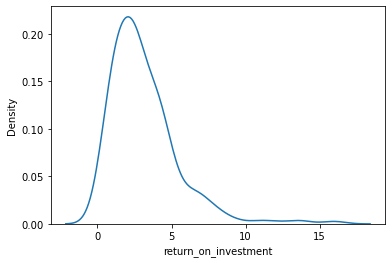

In [23]:
sns.kdeplot(tier4['return_on_investment']);

In [24]:
tier3['return_on_investment'].describe()

count    396.000000
mean       2.652520
std        2.944113
min        0.000000
25%        0.779385
50%        1.864468
75%        3.304330
max       21.317558
Name: return_on_investment, dtype: float64

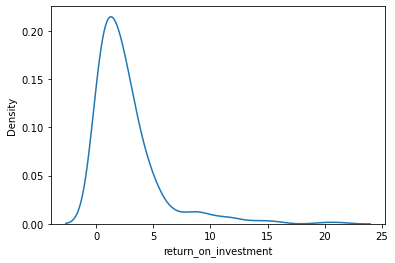

In [25]:
sns.kdeplot(tier3['return_on_investment']);

In [26]:
tier2['return_on_investment'].describe()

count    398.000000
mean       3.921896
std        6.647254
min        0.000000
25%        0.326708
50%        1.723404
75%        5.017671
max       55.792961
Name: return_on_investment, dtype: float64

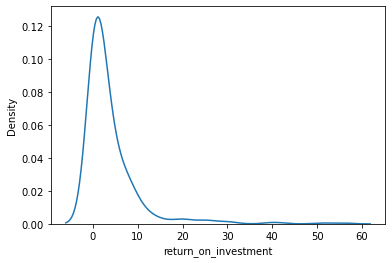

In [27]:
sns.kdeplot(tier2['return_on_investment']);

In [28]:
tier1['return_on_investment'].describe()

count    398.000000
mean       2.656931
std        7.280549
min        0.000000
25%        0.000000
50%        0.051471
75%        1.358549
max       66.580591
Name: return_on_investment, dtype: float64

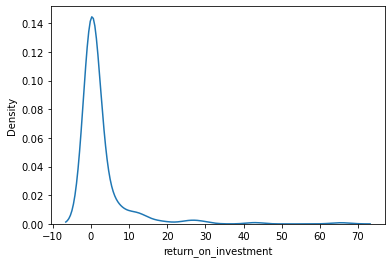

In [29]:
sns.kdeplot(tier1['return_on_investment']);

# ANOVA Test

In [30]:
result = stats.f_oneway(tier1['return_on_investment'], tier2['return_on_investment'], 
                        tier3['return_on_investment'], tier4['return_on_investment'])
result

F_onewayResult(statistic=5.103816845196849, pvalue=0.0016205105429615836)

## Post-Hoc Test

In [31]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [32]:
print(pairwise_tukeyhsd(df_all['return_on_investment'], df_all['budget_tier']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
tier_1 tier_2    1.265 0.0042   0.302  2.2279   True
tier_1 tier_3  -0.0044    0.9 -0.9685  0.9597  False
tier_1 tier_4    0.491 0.5497 -0.4725  1.4545  False
tier_2 tier_3  -1.2694  0.004 -2.2335 -0.3052   True
tier_2 tier_4   -0.774  0.165 -1.7375  0.1896  False
tier_3 tier_4   0.4954  0.544 -0.4693  1.4602  False
----------------------------------------------------


### Tukey's Pairwise Interpretation

1. There is a statistical difference between tier 1 and 2
2. There is a statistical difference between tier 2 and 3

# Plotting & Regression Line

In [33]:
#
tier4_roi_mean = df_all.loc[df_all['budget_tier'] == 'tier_4']['return_on_investment'].mean()
tier3_roi_mean = df_all.loc[df_all['budget_tier'] == 'tier_3']['return_on_investment'].mean()
tier2_roi_mean = df_all.loc[df_all['budget_tier'] == 'tier_2']['return_on_investment'].mean()
tier1_roi_mean = df_all.loc[df_all['budget_tier'] == 'tier_1']['return_on_investment'].mean()
print(tier4_roi_mean, tier3_roi_mean, tier2_roi_mean, tier1_roi_mean)

3.1479290369456003 2.6525196481174804 3.9218958550630787 2.6569312137411556


In [34]:
#creating a new df for tier ROI means
tier_roi_means = {
    'Tiers':[4,3,2,1],
    'ROI_Mean':[tier4_roi_mean, tier3_roi_mean, 
                 tier2_roi_mean, tier1_roi_mean]}
    
roi_means_df = pd.DataFrame(tier_roi_means)
print(roi_means_df)

   Tiers  ROI_Mean
0      4  3.147929
1      3  2.652520
2      2  3.921896
3      1  2.656931


In [35]:
#plotting imports
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

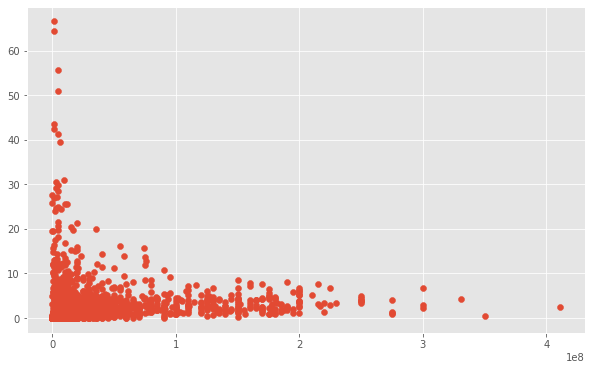

In [36]:
fix, ax = plt.subplots(figsize=(10,6))

ax.scatter(x='production_budget', y='return_on_investment', data=df_all);

## Regression Line

In [37]:
#find slope 'm'
def slope(x, y):
    rho = np.corrcoef(x, y)[0][1]
    s_y = y.std()
    s_x = x.std()

    m = rho * s_y / s_x
    return m
    
m = slope(df_all['production_budget'], df_all['return_on_investment'])

In [38]:
#find intercept 'c'
def intercept(m, x, y):
    y_mean = y.mean()
    x_mean = x.mean()

    # calculating intercept estimate
    c = y_mean - m * x_mean
    return c
    
c = intercept(m, df_all['production_budget'], df_all['return_on_investment'])

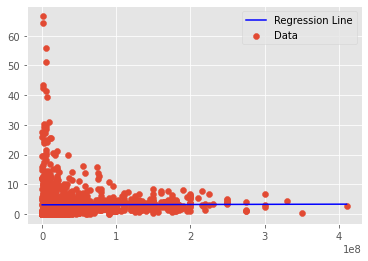

In [39]:
#Plotting the line
def best_fit(x, y):
    # Create a scatter plot of x vs. y
    fig, ax = plt.subplots()
    ax.scatter(x, y, label="Data")

    # Calculate coefficient and intercept
    m = slope(x, y)
    c = intercept(m, x, y)
    
    # Plot line created by coefficient and intercept
    regression_line = m * x + c
    ax.plot(x, regression_line, label= "Regression Line", color='blue')
    ax.legend()
    
best_fit(df_all['production_budget'], df_all['return_on_investment'])

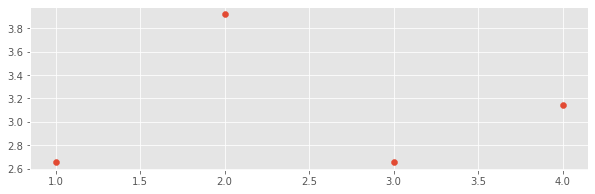

In [40]:
#using means inseatd of raw data
fix, ax = plt.subplots(figsize=(10,3))

ax.scatter(x='Tiers', y='ROI_Mean', data=roi_means_df);

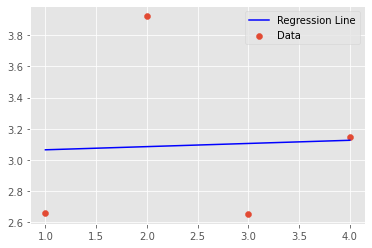

In [41]:
#Plotting the line
def best_fit(x, y):
    # Create a scatter plot of x vs. y
    fig, ax = plt.subplots()
    ax.scatter(x, y, label="Data")

    # Calculate coefficient and intercept
    m = slope(x, y)
    c = intercept(m, x, y)
    
    # Plot line created by coefficient and intercept
    regression_line = m * x + c
    ax.plot(x, regression_line, label= "Regression Line", color='red')
    ax.get_lines()[0].set_color("blue")
    ax.legend()
    
best_fit(roi_means_df['Tiers'], roi_means_df['ROI_Mean'])

## Repeat Process: 2 tiers instead of 4


In [42]:
 #create a list of our conditions
conditions = [
    (df_all['production_budget'] <= 15000000),
    (df_all['production_budget'] > 15000000)]

#create a list of the values we want to assign for each condition
values = ['low_budget', 'high_budget']

#create a new column and use np.select to assign values to it using our lists as arguments
df_all['budget_tier'] = np.select(conditions, values)
df_all

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment,year,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,budget_tier
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2.546673,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624,high_budget
1,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,0.427892,2019,tt6565702,Dark Phoenix,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,high_budget
2,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,4.243841,2015,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,high_budget
3,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,6.827114,2018,tt4154756,Avengers: Infinity War,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,high_budget
4,9,2017-11-17,Justice League,300000000,229024295,655945209,2.186484,2017,tt0974015,Justice League,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135,high_budget
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,59,2011-11-25,The Ridges,17300,0,0,0.000000,2011,tt1781935,The Ridges,The Ridges,89.0,"Drama,Horror,Thriller",2.9,127,low_budget
1587,62,2014-12-31,Stories of Our Lives,15000,0,0,0.000000,2014,tt3973612,Stories of Our Lives,Stories of Our Lives,60.0,Drama,7.5,85,low_budget
1588,73,2012-01-13,Newlyweds,9000,4584,4584,0.509333,2012,tt1880418,Newlyweds,Newlyweds,95.0,"Comedy,Drama",6.4,1436,low_budget
1589,78,2018-12-31,Red 11,7000,0,0,0.000000,2018,tt7837402,Red 11,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,low_budget


In [43]:
low_budget = df_all.loc[df_all['budget_tier'] == 'low_budget']
high_budget = df_all.loc[df_all['budget_tier'] == 'high_budget']

In [44]:
stats.ttest_ind(low_budget['return_on_investment'], high_budget['return_on_investment'])

Ttest_indResult(statistic=1.706279729485746, pvalue=0.08815165845017794)

NOT SIGNIFICANT AT .05


## Horror Genre - Budget & ROI Test

In [45]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1589 entries, 0 to 1590
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    1589 non-null   int64         
 1   release_date          1589 non-null   datetime64[ns]
 2   movie                 1589 non-null   object        
 3   production_budget     1589 non-null   int64         
 4   domestic_gross        1589 non-null   int64         
 5   worldwide_gross       1589 non-null   int64         
 6   return_on_investment  1589 non-null   float64       
 7   year                  1589 non-null   int64         
 8   movie_id              1589 non-null   object        
 9   primary_title         1589 non-null   object        
 10  original_title        1589 non-null   object        
 11  runtime_minutes       1571 non-null   float64       
 12  genres                1587 non-null   object        
 13  averagerating     

In [46]:
df_all.isna().sum() 

id                       0
release_date             0
movie                    0
production_budget        0
domestic_gross           0
worldwide_gross          0
return_on_investment     0
year                     0
movie_id                 0
primary_title            0
original_title           0
runtime_minutes         18
genres                   2
averagerating            0
numvotes                 0
budget_tier              0
dtype: int64

In [47]:
df_all.dropna(subset=['genres'], inplace = True)


In [48]:
def horror(x):
    if "Horror" in x:
        return True
    else:
        return False


In [49]:
df_all['Horror']=df_all['genres'].map(horror)

In [50]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1587 entries, 0 to 1590
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    1587 non-null   int64         
 1   release_date          1587 non-null   datetime64[ns]
 2   movie                 1587 non-null   object        
 3   production_budget     1587 non-null   int64         
 4   domestic_gross        1587 non-null   int64         
 5   worldwide_gross       1587 non-null   int64         
 6   return_on_investment  1587 non-null   float64       
 7   year                  1587 non-null   int64         
 8   movie_id              1587 non-null   object        
 9   primary_title         1587 non-null   object        
 10  original_title        1587 non-null   object        
 11  runtime_minutes       1569 non-null   float64       
 12  genres                1587 non-null   object        
 13  averagerating     

In [51]:
horror_sample = df_all.loc[df_all['Horror']==True]
others_sample= df_all.loc[df_all['Horror']==False]


In [52]:
horror_sample

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment,year,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,budget_tier,Horror
43,69,2013-06-21,World War Z,190000000,202359711,531514650,2.797446,2013,tt0816711,World War Z,World War Z,116.0,"Action,Adventure,Horror",7.0,553751,high_budget,True
60,94,2018-08-10,The Meg,178000000,145443742,529530715,2.974892,2018,tt4779682,The Meg,The Meg,113.0,"Action,Horror,Sci-Fi",5.7,114042,high_budget,True
106,89,2012-05-11,Dark Shadows,150000000,79727149,238202668,1.588018,2012,tt1077368,Dark Shadows,Dark Shadows,113.0,"Comedy,Fantasy,Horror",6.2,229818,high_budget,True
198,12,2017-05-19,Alien: Covenant,97000000,74262031,238521247,2.458982,2017,tt2316204,Alien: Covenant,Alien: Covenant,122.0,"Horror,Sci-Fi,Thriller",6.4,226920,high_budget,True
278,65,2012-06-22,Abraham Lincoln: Vampire Hunter,67500000,37519139,137489730,2.036885,2012,tt1611224,Abraham Lincoln: Vampire Hunter,Abraham Lincoln: Vampire Hunter,105.0,"Action,Fantasy,Horror",5.9,142853,high_budget,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,35,2013-10-25,Her Cry: La Llorona Investigation,35000,0,0,0.000000,2013,tt2469216,Her Cry: La Llorona Investigation,Her Cry: La Llorona Investigation,89.0,Horror,3.7,70,low_budget,True
1581,49,2015-09-01,Exeter,25000,0,489792,19.591680,2015,tt1945044,Exeter,Exeter,91.0,"Horror,Mystery,Thriller",4.5,5156,low_budget,True
1586,59,2011-11-25,The Ridges,17300,0,0,0.000000,2011,tt1781935,The Ridges,The Ridges,89.0,"Drama,Horror,Thriller",2.9,127,low_budget,True
1589,78,2018-12-31,Red 11,7000,0,0,0.000000,2018,tt7837402,Red 11,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,low_budget,True


In [53]:
low_budget_hor = horror_sample.loc[horror_sample['budget_tier'] == 'low_budget']
high_budget_hor = horror_sample.loc[horror_sample['budget_tier'] == 'high_budget']

In [54]:
low_budget_hor['return_on_investment'].mean()

6.376299875399485

In [55]:
high_budget_hor['return_on_investment'].mean()

2.66466076579254

In [56]:
result = stats.ttest_ind(low_budget_hor['return_on_investment'], high_budget_hor['return_on_investment'])
pval = result[1]/2
print(pval)

0.012884527420547093


### There is a statistically significant difference between ROIs of horror movies with low budget vs. high budget!


## Plotting the regression line & Calculating R-squared

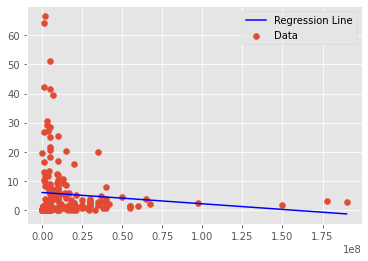

In [57]:
#Plotting the line for ENTIRE HORROR SAMPLE
def best_fit(x, y):
    # Create a scatter plot of x vs. y
    fig, ax = plt.subplots()
    ax.scatter(x, y, label="Data")

    # Calculate coefficient and intercept
    m = slope(x, y)
    c = intercept(m, x, y)
    
    # Plot line created by coefficient and intercept
    regression_line = m * x + c
    ax.plot(x, regression_line, label= "Regression Line", color='red')
    ax.get_lines()[0].set_color("blue")
    ax.legend()
    
best_fit(horror_sample['production_budget'], horror_sample['return_on_investment'])


### Creating ROI Mean & Budget Tier DF to plot Regression Line

In [58]:
#create a list of our conditions
conditions = [
    (horror_sample['production_budget'] <= 7500000),
    (horror_sample['production_budget'] > 7500000) & (horror_sample['production_budget'] <= 11000000),
    (horror_sample['production_budget'] > 1100000) & (horror_sample['production_budget'] <= 15000000),
    (horror_sample['production_budget'] > 15000000)]

#create a list of the values we want to assign for each condition
values = ['tier_1', 'tier_2', 'tier_3', 'tier_4']

#create a new column and use np.select to assign values to it using our lists as arguments
horror_sample['Tier'] = np.select(conditions, values)
horror_sample

<ipython-input-58-6c56ab027009>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horror_sample['Tier'] = np.select(conditions, values)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment,year,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,budget_tier,Horror,Tier
43,69,2013-06-21,World War Z,190000000,202359711,531514650,2.797446,2013,tt0816711,World War Z,World War Z,116.0,"Action,Adventure,Horror",7.0,553751,high_budget,True,tier_4
60,94,2018-08-10,The Meg,178000000,145443742,529530715,2.974892,2018,tt4779682,The Meg,The Meg,113.0,"Action,Horror,Sci-Fi",5.7,114042,high_budget,True,tier_4
106,89,2012-05-11,Dark Shadows,150000000,79727149,238202668,1.588018,2012,tt1077368,Dark Shadows,Dark Shadows,113.0,"Comedy,Fantasy,Horror",6.2,229818,high_budget,True,tier_4
198,12,2017-05-19,Alien: Covenant,97000000,74262031,238521247,2.458982,2017,tt2316204,Alien: Covenant,Alien: Covenant,122.0,"Horror,Sci-Fi,Thriller",6.4,226920,high_budget,True,tier_4
278,65,2012-06-22,Abraham Lincoln: Vampire Hunter,67500000,37519139,137489730,2.036885,2012,tt1611224,Abraham Lincoln: Vampire Hunter,Abraham Lincoln: Vampire Hunter,105.0,"Action,Fantasy,Horror",5.9,142853,high_budget,True,tier_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,35,2013-10-25,Her Cry: La Llorona Investigation,35000,0,0,0.000000,2013,tt2469216,Her Cry: La Llorona Investigation,Her Cry: La Llorona Investigation,89.0,Horror,3.7,70,low_budget,True,tier_1
1581,49,2015-09-01,Exeter,25000,0,489792,19.591680,2015,tt1945044,Exeter,Exeter,91.0,"Horror,Mystery,Thriller",4.5,5156,low_budget,True,tier_1
1586,59,2011-11-25,The Ridges,17300,0,0,0.000000,2011,tt1781935,The Ridges,The Ridges,89.0,"Drama,Horror,Thriller",2.9,127,low_budget,True,tier_1
1589,78,2018-12-31,Red 11,7000,0,0,0.000000,2018,tt7837402,Red 11,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,low_budget,True,tier_1


In [59]:
tier4_hor = horror_sample.loc[horror_sample['Tier'] == 'tier_4']
tier3_hor = horror_sample.loc[horror_sample['Tier'] == 'tier_3']
tier2_hor = horror_sample.loc[horror_sample['Tier'] == 'tier_2']
tier1_hor = horror_sample.loc[horror_sample['Tier'] == 'tier_1']

In [60]:
tier4_hor_roim = horror_sample.loc[horror_sample['Tier'] == 'tier_4']['return_on_investment'].mean()
tier3_hor_roim = horror_sample.loc[horror_sample['Tier'] == 'tier_3']['return_on_investment'].mean()
tier2_hor_roim = horror_sample.loc[horror_sample['Tier'] == 'tier_2']['return_on_investment'].mean()
tier1_hor_roim = horror_sample.loc[horror_sample['Tier'] == 'tier_1']['return_on_investment'].mean()
print(tier4_hor_roim, tier3_hor_roim, tier2_hor_roim, tier1_hor_roim)

2.66466076579254 5.751416179443601 6.442151812147419 6.428008095425264


In [61]:
#creating a new df for tier ROI means
horror_roi_means = {
    'Tiers':[4,3,2,1],
    'ROI_Mean':[tier4_hor_roim, tier3_hor_roim, tier2_hor_roim, tier1_hor_roim]}
    
horror_roi_means_df = pd.DataFrame(horror_roi_means)
print(horror_roi_means_df)

   Tiers  ROI_Mean
0      4  2.664661
1      3  5.751416
2      2  6.442152
3      1  6.428008


(None, 5.065891981117695e-10, 3.0756379868559836)

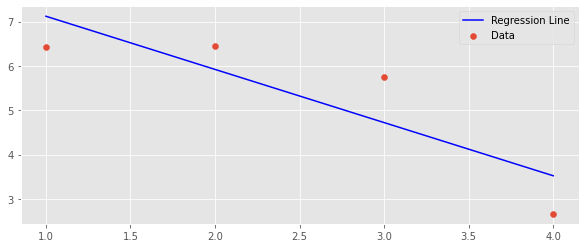

In [62]:
#Plotting the line
def best_fit(x, y):
    # Create a scatter plot of x vs. y
    fig, ax = plt.subplots(figsize=(10,4))
    ax.scatter(x, y, label="Data")

    # Calculate coefficient and intercept
    m = slope(x, y)
    c = intercept(m, x, y)
    
    # Plot line created by coefficient and intercept
    regression_line = m * x + c
    ax.plot(x, regression_line, label= "Regression Line", color='red')
    ax.get_lines()[0].set_color("blue")
    ax.legend()
    
best_fit(horror_roi_means_df['Tiers'], horror_roi_means_df['ROI_Mean']), m, c

In [63]:
horror_roi_means_array = horror_roi_means_df['ROI_Mean'].array

In [64]:
horror_tier_array = horror_roi_means_df[["Tiers"]] 

In [65]:
from sklearn.linear_model import LinearRegression

#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = horror_tier_array, horror_roi_means_array

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)

#view R-squared value
print(r_squared)

0.7380776735469958
